In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *

sampling_indices = (3, 4)

## Generate many objects in parallel

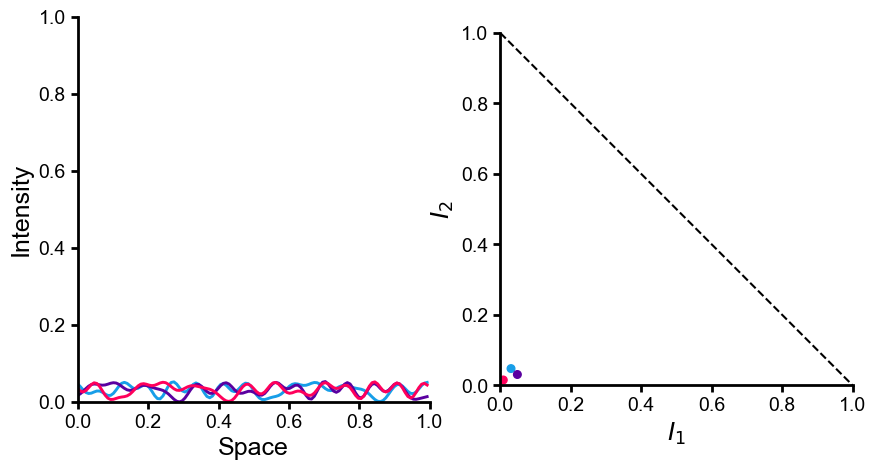

In [2]:
n_objects = 20
objects = np.array([sample_amplitude_object('delta') for i in range(n_objects)])

# generate random convolution kernel
random_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
conv_mat = make_convolutional_encoder(random_kernel)

output_signals = objects @ conv_mat.T 


sampling_indices = (3, 4)
num_to_plot = 3

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], output_signals[:num_to_plot], sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1], output_signals[:num_to_plot], sample_point_indices=sampling_indices, differentiate_colors=True)

## Show example objects

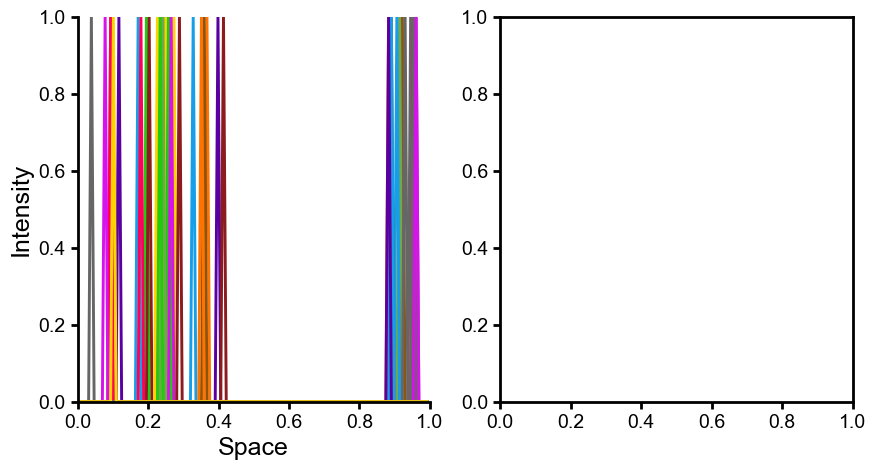

In [3]:
n_objects = 40
objects = np.array([sample_amplitude_object('delta', gaussian_mixture_position=True) for i in range(n_objects)])
# objects = np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(n_objects)])

# plot all the objects
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_in_spatial_coordinates(ax[0], objects, sample_point_indices=sampling_indices, plot_lim=1)



## Optimize an encoder based on entropy as a loss function

In [25]:
N_objects = 2000
objects = np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=True) for i in range(N_objects)])
objects = np.array([sample_amplitude_object('delta', num_deltas=1, gaussian_mixture_position=True) for i in range(N_objects)])

entropies = []
num_samples = np.arange(2, NUM_NYQUIST_SAMPLES * 2, 9).astype(int)
for N in tqdm(num_samples):
  erasure_mask = onp.zeros(OBJECT_LENGTH)
  sample_indices = onp.linspace(0, OBJECT_LENGTH - 1, N).astype(int)
  erasure_mask[sample_indices] = 1
  erasure_mask = np.array(erasure_mask, dtype=bool)
  sampling_indices = (1, 2)




  initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())
  # initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.5)

  initial_params = np.concatenate(real_imag_params_from_signal(initial_kernel))

  loss_fn = make_convolutional_forward_model_and_entropy_loss_fn_and_erasure(objects, erasure_mask, nyquist_sample_output=False)
  optimized_params = run_optimzation(loss_fn, real_imag_bandlimit_energy_norm_prox_fn, 
                          initial_params,
                            learning_rate=1e-4, learning_rate_decay=0.999,
                            verbose=True,
                          loss_improvement_patience=2000, max_epochs=5000)
  optimized_loss = loss_fn(optimized_params)
  entropies.append(optimized_loss)


  0%|          | 0/7 [00:00<?, ?it/s]

initial loss 18.904783054451023


 14%|█▍        | 1/7 [01:13<07:22, 73.69s/it]

initial loss 94.0538152912488


 29%|██▊       | 2/7 [02:37<06:37, 79.54s/it]

initial loss 202.32486826358326


 43%|████▎     | 3/7 [04:01<05:26, 81.56s/it]

initial loss 317.74867399683205


 57%|█████▋    | 4/7 [05:35<04:20, 86.68s/it]

initial loss 484.07248650149967


 71%|███████▏  | 5/7 [06:54<02:47, 83.64s/it]

initial loss 690.0753222063248


 86%|████████▌ | 6/7 [08:12<01:21, 81.70s/it]

initial loss 885.4387914448711


100%|██████████| 7/7 [09:33<00:00, 81.97s/it]

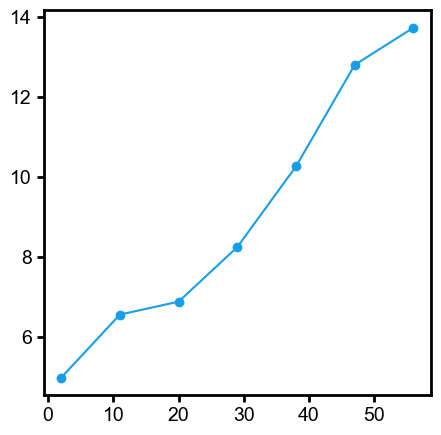

In [27]:

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(num_samples, entropies, 'o-')


In [21]:
num_samples

[128.0, 64.0, 32.0, 16.0, 8.0, 4.0, 2.0]

Text(0.5, 1.0, 'Object')

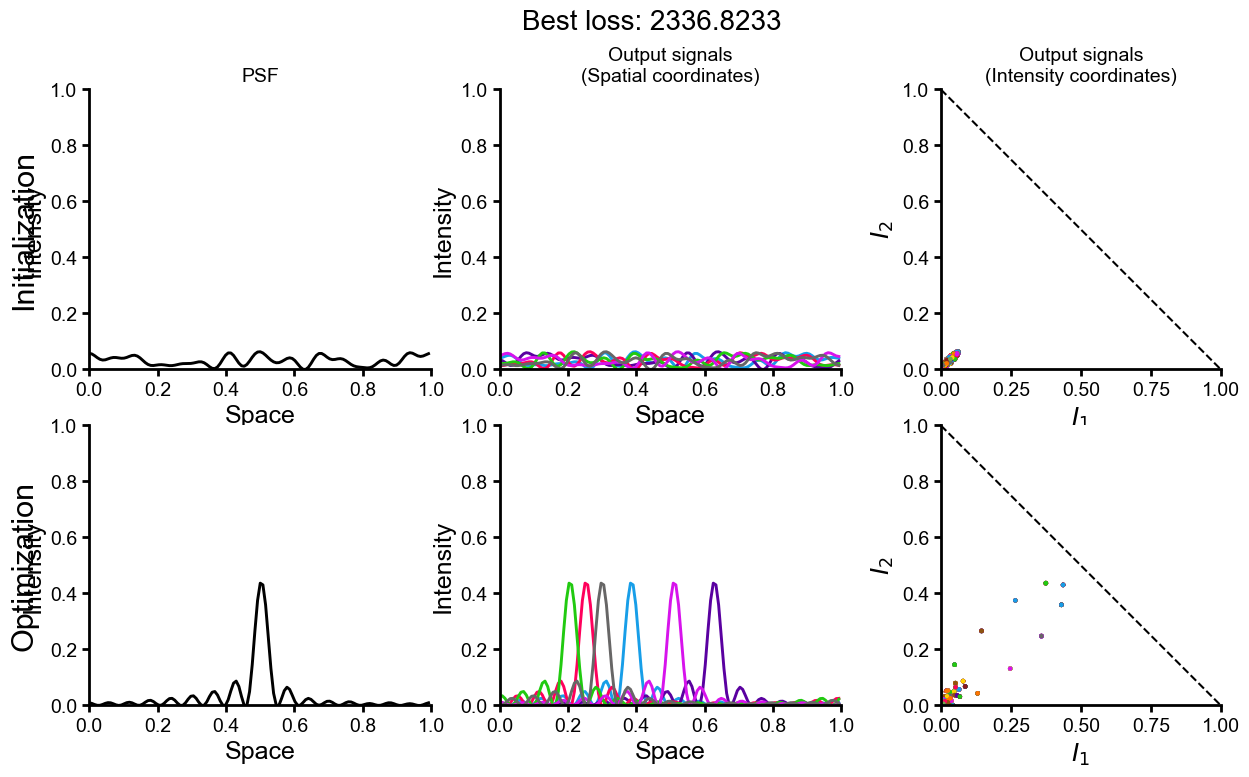

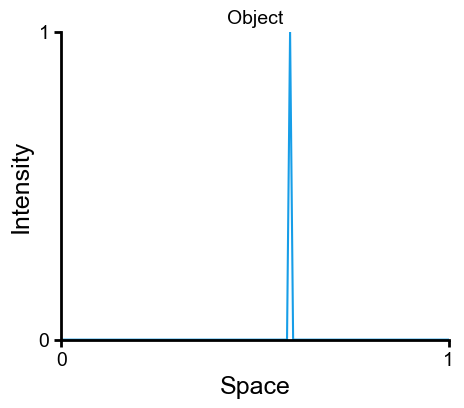

In [11]:
N_objects_to_plot = 1
N_signals_to_plot = 6


# plot the initial and optimized convolutional encoders
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

plot_in_spatial_coordinates(ax[0, 0], initial_kernel, show_samples=False, center=True)
plot_in_spatial_coordinates(ax[1, 0], signal_from_real_imag_param_vec(optimized_params), show_samples=False, center=True)
ax[0,0].set_title('PSF')


ax[0, 0].text(-0.15, 0.5, 'Initialization', transform=ax[0, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)           
ax[1, 0].text(-0.15, 0.5, 'Optimization', transform=ax[1, 0].transAxes,
            rotation=90, va='center', ha='right', fontsize=22)       

# plot the output signals
plot_in_spatial_coordinates(ax[0, 1], conv_forward_model_with_erasure(initial_params, objects[:N_signals_to_plot], erasure_mask, nyquist_sample_output=False), 
                            show_samples=False)
plot_in_spatial_coordinates(ax[1, 1], conv_forward_model_with_erasure(optimized_params, objects[:N_signals_to_plot], erasure_mask, nyquist_sample_output=False), 
                            show_samples=False)
ax[0,1].set_title('Output signals\n(Spatial coordinates)')

# plot the output signals in intensity coordinates
plot_in_intensity_coordinates(ax[0, 2], conv_forward_model_with_erasure(initial_params, objects, erasure_mask, nyquist_sample_output=False),
                               markersize=5, differentiate_colors=True, sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[1, 2], conv_forward_model_with_erasure(optimized_params, objects, erasure_mask, nyquist_sample_output=False),
                               markersize=5, differentiate_colors=True, sample_point_indices=sampling_indices)
ax[0,2].set_title('Output signals\n(Intensity coordinates)')
fig.suptitle(f'Best loss: {optimized_loss:.4f}', fontsize=20)
